# Data preprocessing

### Directly train your models by using the following data in your network models:

train_padded, train_rating - Training sequences and overall ratings respectively <br />
test_padded, test_rating - Testing sequences and overall ratings respectively

In [2]:
# Importing the libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from nltk.corpus import stopwords
import string
import re
import gzip
import json
%matplotlib inline

In [3]:
# Importing the dataset

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

path = 'data/Video_Games_5.json.gz'
dataset = getDF(path)
dataset.shape


(497577, 12)

In [10]:
"""
A utility function to remove non alphabetical characters from the text.

"""

def clean_noncharacters(text):
    # Removing punctuations
    text  = "".join([char for char in text if char not in string.punctuation])
    # Removing numerics
    text = re.sub('[0-9]+', '', text)
    return text


"""
A utility function to remove URL links from the text.

"""

def clean_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove stopwords from the text.

"""

def clean_stopwords(text):
    stop_words = set(stopwords.words('english'))
    res = [w for w in text.split() if not w in stop_words]
    res_string = " ".join(str(x) for x in res)
    return res_string

In [11]:
# Apply above preprocessing methods to the dataset

dataset["reviewText"] = dataset["reviewText"].apply(lambda x : clean_noncharacters(str(x)))
dataset["reviewText"] = dataset["reviewText"].apply(lambda x : clean_URL(str(x)))
dataset["reviewText"] = dataset["reviewText"].apply(lambda x : clean_stopwords(str(x)))

dataset.head(10)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,This game bit hard get hang great,but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played alright The steam bit trouble The mov...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,found game bit complicated I expected played,Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,great game I love played since arrived,love this game,1419465600,NaN,NaN,NaN
5,4.0,True,"11 13, 2014",A11V6ZJ2FVQY1D,0700026657,IBRAHIM ALBADI,liked lot time havent play wonderfull game sim...,Anno 2070,1415836800,NaN,NaN,NaN
6,1.0,False,"08 2, 2014",A1KXJ1ELZIU05C,0700026657,Creation27,Im avid gamer Anno INSULT gaming It buggy half...,Avoid This Game - Filled with Bugs,1406937600,NaN,NaN,NaN
7,5.0,True,"03 3, 2014",A1WK5I4874S3O2,0700026657,WhiteSkull,I bought game thinking would pretty cool might...,A very good game balance of skill with depth o...,1393804800,NaN,NaN,NaN
8,5.0,True,"02 21, 2014",AV969NA4CBP10,0700026657,Travis B. Moore,I played old anno AND game looks great complex...,Anno 2070 more like anno 1701,1392940800,NaN,NaN,NaN
9,4.0,True,"06 27, 2013",A1EO9BFUHTGWKZ,0700026657,johnnyz3,I liked fun played got moneys worth You certai...,Pretty fun,1372291200,NaN,NaN,NaN


In [7]:
# Removing the rows with "overall" values not in range 1.0-5.0

dataset = dataset[dataset['overall'].apply(lambda x: x in ["1.0", "2.0", "3.0", "4.0", "5.0"])]
dataset.head()

KeyError: 'overall'

In [45]:
# Shortening the dataset by removing all the columns except reviewText and overall

dataset_short = dataset[["reviewText","overall"]]
dataset_short.head()

,reviewText,overall


In [46]:
def apply_polarity(row):
    if int(float(row["overall"])) > 3:
        return 1
    elif int(float(row["overall"])) == 3:
        return 0
    else:
        return -1

In [27]:
dataset_short['polarity'] = dataset_short.apply(lambda row: apply_polarity(row), axis=1)

ValueError: Wrong number of items passed 2, placement implies 1

In [28]:
dataset_short.head(20)

,reviewText,overall


In [99]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [131]:
# Importing the tokenizer and pad_sequences libraries

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Setting the random seed so that rows shuffle in the same way in every session.

tf.random.set_seed(100)


# vocab_size - size of the vocabulary (unique words in the data corpus)
# trunc_type - whether to truncate the sentence from behind or start (in case if sentence length
# padding_type - whether to pad the short sentences from behind or start
# oov_tok - replace the out of vocab word with a token
# training_size - size of training data
# max_length - maximum length of a sentence sequence

vocab_size = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV_TOKEN>"
training_size = int(len(dataset_short)*0.6)
max_length = 100


# Shuffle the rows
dataset_short = dataset_short.sample(frac=1).reset_index(drop=True)

# Splitting the train and the test sentences list.

temp = [str(x) for x in dataset_short["reviewText"].tolist()]
train_reviews = temp[:training_size]
test_reviews = temp[training_size:]

# Splitting the train and the test labels list.

temp2 = [x for x in dataset_short["polarity"].tolist()]
train_rating = temp2[:training_size]
test_rating = temp2[training_size:]

In [101]:
# Tokenize the words
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_reviews)


# Convert sentence reviews to sequences
train_sequences = tokenizer.texts_to_sequences(train_reviews)
# Convert sequences to padded sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


# Convert sentence reviews to sequences
test_sequences = tokenizer.texts_to_sequences(test_reviews)
# Convert sequences to padded sequences
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [102]:
# Converting all the data to numpy arrays

from tensorflow.keras.utils import to_categorical

train_padded = np.array(train_padded)
train_rating = np.array(train_rating)
test_padded = np.array(test_padded)
test_rating = np.array(test_rating)


train_rating_encoded = to_categorical(train_rating, num_classes = 3)
test_rating_encoded = to_categorical(test_rating, num_classes = 3)

train_padded = np.array(train_padded)
train_rating_encoded = np.array(train_rating_encoded)

test_padded = np.array(test_padded)
test_rating_encoded = np.array(test_rating_encoded)

In [103]:
train_rating_encoded[-5:]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [104]:
train_rating[-5:]

array([1, 0, 1, 1, 1])

In [123]:

embedding_dim = 100

dnn_model = tf.keras.Sequential([
        
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),    
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(5, activation = "relu"),
    tf.keras.layers.Dense(3, activation = "softmax")
])

# Compile the model
dnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/10
3435/3435 [==============================] - 9s 3ms/step - loss: 0.6817 - accuracy: 0.7572 - val_loss: 0.6644 - val_accuracy: 0.7554
Epoch 2/10
3435/3435 [==============================] - 9s 2ms/step - loss: 0.6601 - accuracy: 0.7593 - val_loss: 0.6619 - val_accuracy: 0.7561
Epoch 3/10
3435/3435 [==============================] - 9s 3ms/step - loss: 0.6546 - accuracy: 0.7597 - val_loss: 0.6607 - val_accuracy: 0.7571
Epoch 4/10
3435/3435 [==============================] - 10s 3ms/step - loss: 0.6532 - accuracy: 0.7605 - val_loss: 0.6574 - val_accuracy: 0.7566
Epoch 5/10
3435/3435 [==============================] - 11s 3ms/step - loss: 0.6526 - accuracy: 0.7605 - val_loss: 0.6568 - val_accuracy: 0.7567
Epoch 6/10
3435/3435 [==============================] - 11s 3ms/step - loss: 0.6519 - accuracy: 0.7604 - val_loss: 0.6572 - val_accuracy: 0.7567


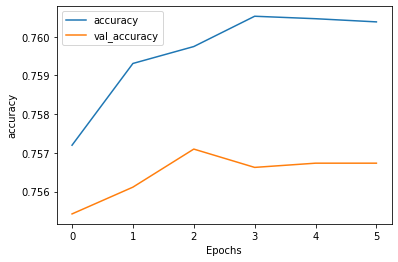

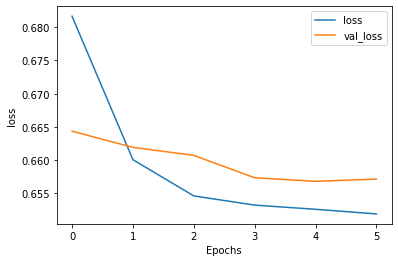

In [124]:
num_epochs = 10

early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

dnn_history = dnn_model.fit(train_padded, train_rating_encoded, epochs=num_epochs, validation_split = 0.2, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

plot_graphs(dnn_history, "accuracy")
plot_graphs(dnn_history, "loss")

In [127]:
test_pred_classes = []
test_predictions = lstm_model.predict(test_padded)

i = 0
for probs in test_predictions:
    if(probs[0] > probs[1] and probs[0] > probs[2]):
        test_pred_classes.append(0)
    if(probs[1] > probs[0] and probs[1] > probs[2]):
        test_pred_classes.append(1)
    if(probs[2] > probs[0] and probs[2] > probs[1]):
        test_pred_classes.append(-1)

In [128]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_rating, test_pred_classes))

0.7547250155589768


In [129]:
embedding_dim = 100

lstm_model = tf.keras.Sequential([
    
    
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),    
    tf.keras.layers.LSTM(18),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3, activation = "softmax")
    
    ])

# Compile the model
lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/10
3435/3435 [==============================] - 141s 41ms/step - loss: 0.7213 - accuracy: 0.7565 - val_loss: 0.7195 - val_accuracy: 0.7537
Epoch 2/10
3435/3435 [==============================] - 141s 41ms/step - loss: 0.7135 - accuracy: 0.7567 - val_loss: 0.7017 - val_accuracy: 0.7537
Epoch 3/10
3435/3435 [==============================] - 140s 41ms/step - loss: 0.7018 - accuracy: 0.7567 - val_loss: 0.6776 - val_accuracy: 0.7537
Epoch 4/10
3435/3435 [==============================] - 140s 41ms/step - loss: 0.6674 - accuracy: 0.7581 - val_loss: 0.6621 - val_accuracy: 0.7568
Epoch 5/10
3435/3435 [==============================] - 140s 41ms/step - loss: 0.6552 - accuracy: 0.7609 - val_loss: 0.6536 - val_accuracy: 0.7573
Epoch 6/10
3435/3435 [==============================] - 144s 42ms/step - loss: 0.6484 - accuracy: 0.7610 - val_loss: 0.6480 - val_accuracy: 0.7579
Epoch 7/10
3435/3435 [==============================] - 151s 44ms/step - loss: 0.6431 - accuracy: 0.7618 - val_loss: 0

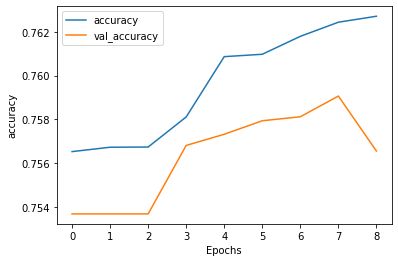

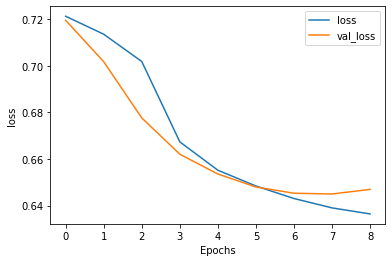

In [130]:
num_epochs = 10

early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(train_padded, train_rating_encoded, epochs=num_epochs, validation_split = 0.2, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

plot_graphs(lstm_history, "accuracy")
plot_graphs(lstm_history, "loss")

# Documentation IMP

1. Data preprocessing. - dhrumil
2. Network 1 - amogh
3. LSTM overview - pros over regular - vivek
4. Network 2 - vivek
5. Loss curves - amogh
6. conclusion - sharjeel